<a href="https://colab.research.google.com/github/InbumS/DreamscomeTrue/blob/main/BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift ##

이름만 해석해봐 ! ==> Batch에 대해 random하다.

Cause by Gradient vanishing problem

각각의 layer에 적합한 감마, 베타를 찾아내는 방식

* 학습을 빠르게 진행할 수 있다.(높은 학습률을 적용 가능합니다)

* 초깃값에 크게 의존하지 않는다.(초깃값 선택 장애를 개선했습니다)

* 오버피팅을 억제합니다.(드랍아웃의 필요성을 감소했습니다.)

* 비선형 함수(sigmoid 등)을 이용할 때, saturated regime(기울기가 0인 부분)    에빠지는 것을 방지합니다. 따라서 기울기 소실과 saturation problem을 예방합니다.



배치정규화 => 내부 공변량을 감소시키는 방향

신경망이 깊어질 때 마다 activation의 분포가 바뀌어 간다.


## whitening 기법

평균 0, 분산 1로 decorrelated(비상관화) 해주는 선형 변환

각 layer의 입력값에 whitening을 적용시키면 internal covariate shift를 감소시킬 수 있을 것이라고 말한다.

문제점😠

* covariance matrix 계산과 inverse 계산이 필요하기 때문에 계산량이 많다.

* whitening을 하면 일부 파라미터들의 영향이 무시되어 gradient descent 효과를 감소 ==> 입력 값 X를 받아 Z = WX + b 라는 결과를 내놓고 적절한 bias b 를 학습하려는 네트워크에서 기댓값 : Z에 E(Z), b 값이 결국 빠지게 되고, 결과적으로 b의 영향은 없어짐

단순히 E(Z)를 빼는 것이 아니라 표준편차로 나눠주는 등의 scaling 과정까지 포함될 경우 더 악화됨.




독립적으로 normalize 해버리기



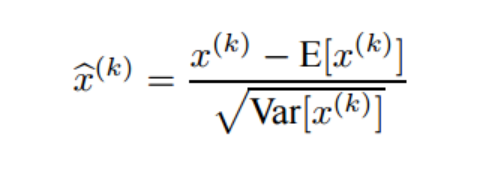


* 최종적 미니 배치를 고려한 배치 정규화 수식


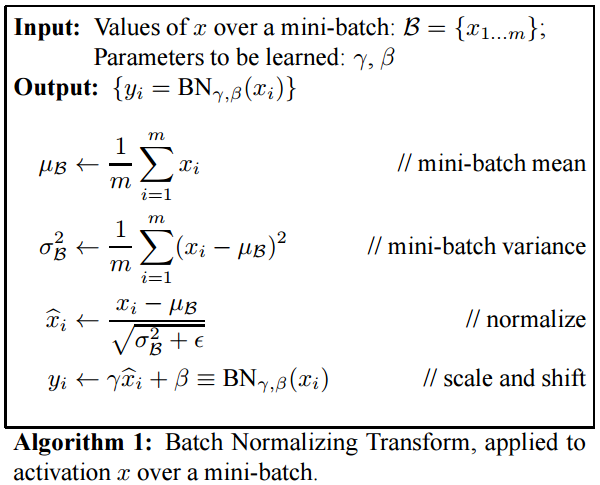

신경망 안에 포함되어 학습시 평균과 분산이 같이 조정된다.
배치 정규화는 output 즉 활성화 함수의 값이  output = g(BN(Z)), Z = WX + b으로 변한다.

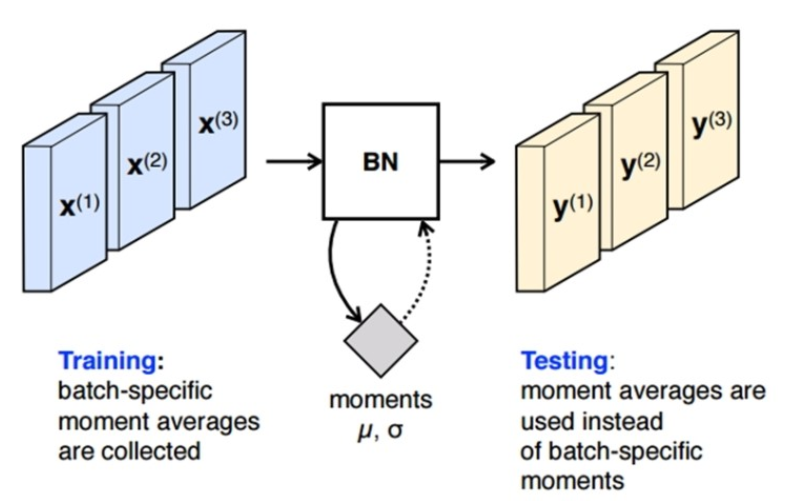

학습 시에는 배치 정규화의 미니 배치의 평균과 분산을 이용 할 수 있지만, 추론(inference) 및 테스트 할 때에는 이를 이용할 수 없다. inference 시 입력되는 데이터의 평균과 분산을 이용하면 배치 정규화가 온전하게 이루어지지 않는다. 애초에 배치 정규화를 통해 수행하고자 하는 것이 학습되는 동안 모델이 추정한 입력 데이터 분포의 평균과 분산으로 정규화를 하고자 하는 것인데 inference 시에 입력되는 값을 통해서 정규화를 하게 되면 모델이 학습을 통해서 입력 데이터의 분포를 추정하는 의미 자체가 없어지게 된다. 즉, inference 에서는 결과를 Deterministic 하게 하기 위하여 고정된 평균과, 분산을 이용하여 정규화를 수행하게 된다. 그래서 Train 모드와 Test 모드를 따로 두는 이유이기도 하다.



그래서 사용되는게 미니배치의 이동평균을 사용한다. 미니 배치를 뽑을 시 각각의 이동평균을 구해 unbiased variance 방법을 이용한다.

# Real effect of BN?

MIT연구진에 의한 논문

BN이 performance를 개선은 맞음

loss function의 surface를 smooth하게 만드는 효과가 있을 뿐, 공변량 변화를 주는 것은 아니다.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, 
                                           transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         transform=transforms.ToTensor(), download=True)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(trainloader)
test_total_batch = len(testloader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in trainloader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(trainloader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(testloader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')